## Customer Segmentation using RFM Analysis
This project performs customer segmentation using RFM (Recency, Frequency, Monetary) analysis on the Online Retail dataset. RFM analysis is a proven marketing technique for segmenting customers based on their transaction history, allowing businesses to develop targeted marketing strategies for different customer groups.

## Key Insights
- The dataset contains 4,373 unique customers from 38 different countries

- The UK represents the vast majority of customers (over 90%)

- Best Customers represent a small percentage of the customer base but contribute significantly to revenue

- There's a large group of Lost Customers who haven't purchased recently and represent an opportunity for re-engagement campaigns

## Import Libraries

In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter("ignore", FutureWarning)

# Set style for visualizations
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("Set2")


## Load Dataset

In [94]:
df = pd.read_csv("Online Retail.csv")

# Display basic info
print("Dataset Shape:", df.shape)
df.head()


Dataset Shape: (541909, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/10 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/10 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/10 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/10 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/10 8:26,3.39,17850.0,United Kingdom


## Dataset Info and Summary Stats

In [103]:
print("Data info:")
display(df.info())

print("\nSummary statistics (numeric):")
display(df.describe().T)

print("Missing Values:")
print(df.isnull().sum())

Data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


None


Summary statistics (numeric):


,count,mean,std,min,25%,50%,75%,max
Quantity,541909.0,9.552250,218.081158,-80995.00,1.00,3.00,10.00,80995.0
UnitPrice,541909.0,4.611114,96.759853,-11062.06,1.25,2.08,4.13,38970.0
CustomerID,406829.0,15287.690570,1713.600303,12346.00,13953.00,15152.00,16791.00,18287.0


Missing Values:
InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64


## Data Cleaning

In [85]:
# Remove rows with missing CustomerID
df_clean = df[df['CustomerID'].notna()].copy()

# Convert InvoiceDate to datetime
df_clean['InvoiceDate'] = pd.to_datetime(df_clean['InvoiceDate'], format='%m/%d/%y %H:%M')

# Convert CustomerID to integer
df_clean['CustomerID'] = df_clean['CustomerID'].astype(int)

# Remove negative quantities and prices (returns or cancellations)
df_clean = df_clean[df_clean['Quantity'] > 0]
df_clean = df_clean[df_clean['UnitPrice'] > 0]

# Create TotalPrice column
df_clean['TotalPrice'] = df_clean['Quantity'] * df_clean['UnitPrice']

# Check for duplicates
print("Duplicate rows:", df_clean.duplicated().sum())

# Remove duplicates
df_clean = df_clean.drop_duplicates()

print("Cleaned dataset shape:", df_clean.shape)

Duplicate rows: 5192
Cleaned dataset shape: (392692, 9)


## RFM Analysis

In [86]:
# Set a reference date for recency calculation (one day after the last invoice)
reference_date = df_clean['InvoiceDate'].max() + pd.Timedelta(days=1)

# Calculate RFM metrics
rfm = df_clean.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days,  # Recency
    'InvoiceNo': 'count',  # Frequency
    'TotalPrice': 'sum'  # Monetary
}).rename(columns={'InvoiceDate': 'Recency', 'InvoiceNo': 'Frequency', 'TotalPrice': 'Monetary'})

# Display RFM metrics
rfm.head()

,Recency,Frequency,Monetary
CustomerID,,,
12346,326,1,77183.60
12347,2,182,4310.00
12348,75,31,1797.24
12349,19,73,1757.55
12350,310,17,334.40


## RFM Scoring

In [87]:
# Assign Scores (1-4 scale)
rfm["R_Score"] = pd.qcut(rfm["Recency"], 4, labels=[4,3,2,1]).astype(int)
rfm["F_Score"] = pd.qcut(rfm["Frequency"].rank(method="first"), 4, labels=[1,2,3,4]).astype(int)
rfm["M_Score"] = pd.qcut(rfm["Monetary"], 4, labels=[1,2,3,4]).astype(int)

# Final RFM Score
rfm["RFM_Segment"] = rfm["R_Score"].map(str) + rfm["F_Score"].map(str) + rfm["M_Score"].map(str)
rfm["RFM_Score"] = rfm[["R_Score","F_Score","M_Score"]].sum(axis=1)

rfm.head(10)


,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Segment,RFM_Score
CustomerID,,,,,,,,
12346,326,1,77183.60,1,1,4,114,6
12347,2,182,4310.00,4,4,4,444,12
12348,75,31,1797.24,2,2,4,224,8
12349,19,73,1757.55,3,3,4,334,10
12350,310,17,334.40,1,1,2,112,4
12352,36,85,2506.04,3,3,4,334,10
12353,204,4,89.00,1,1,1,111,3
12354,232,58,1079.40,1,3,3,133,7
12355,214,13,459.40,1,1,2,112,4


## Customer Segmentation

In [88]:
# Define Customer Segments
def segment_customer(score):
    if score >= 9:
        return "Loyal Customers"
    elif score >= 7:
        return "Potential Loyalist"
    elif score >= 5:
        return "Needs Attention"
    else:
        return "At Risk"

rfm["Segment"] = rfm["RFM_Score"].apply(segment_customer)

rfm["Segment"].value_counts()


Segment
Loyal Customers       1682
Needs Attention        975
Potential Loyalist     919
At Risk                762
Name: count, dtype: int64

## Visualization

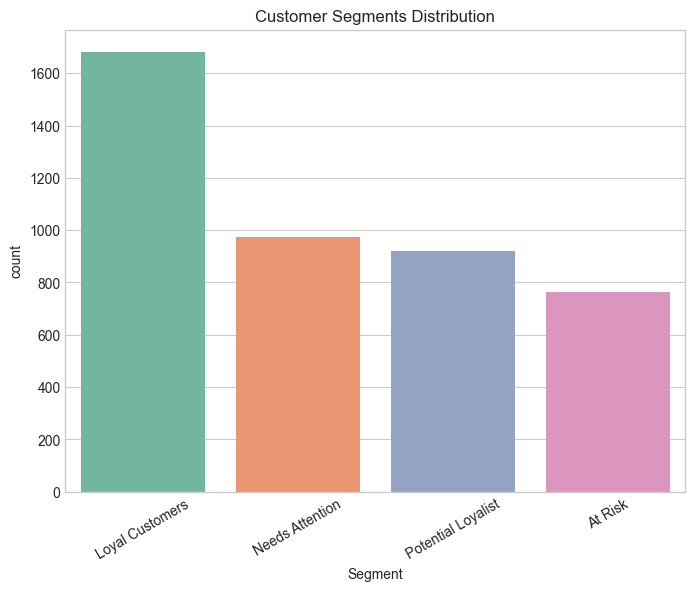

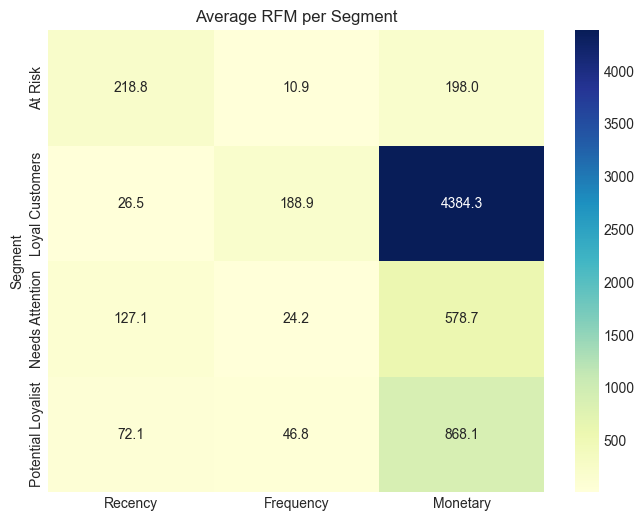

In [89]:
plt.figure(figsize=(8,6))
sns.countplot(data=rfm, x="Segment", order=rfm["Segment"].value_counts().index, palette="Set2")
plt.title("Customer Segments Distribution")
plt.xticks(rotation=30)
plt.show()

# Heatmap for RFM
rfm_agg = rfm.groupby("Segment").agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean'
}).round(1)
plt.figure(figsize=(8,6))
sns.heatmap(rfm_agg, annot=True, fmt=".1f", cmap="YlGnBu")
plt.title("Average RFM per Segment")
plt.show()


## Marketing Ideas

In [92]:
# Define marketing strategies for each segment
marketing_strategies = {
    'Loyal Customers': {
        'Description': 'Frequent buyers but not necessarily recent or high spenders',
        'Strategies': [
            'Loyalty rewards program',
            'Special discounts on frequently bought items',
            'Early access to new products',
            'Referral programs'
        ]
    },
    'Potential Loyalists': {
        'Description': 'Recent customers with moderate frequency and spending',
        'Strategies': [
            'Upsell higher value products',
            'Personalized email campaigns',
            'Limited-time offers to increase frequency',
            'Offer small discounts',
        ]
    },
    'Need Attention Customers': {
        'Description': 'Previously frequent but not recent customers',
        'Strategies': [
            'Win-back campaigns with special offers',
            'Re-engagement emails',
            'Surveys to understand why they stopped purchasing',
            'Limited-time discounts to encourage return'
        ]
    },
    'At Risk Customers': {
        'Description': 'Not recent, not frequent, and low spending customers',
        'Strategies': [
            'Aggressive reactivation campaigns',
            'Deep discounts on first purchase back',
            'Exit surveys to understand churn reasons',
            'Focus resources on more promising segments'
        ]
    }
}

# Display marketing strategies
for segment, info in marketing_strategies.items():
    print(f"\n{segment}: {info['Description']}")
    print("Marketing Strategies:")
    for i, strategy in enumerate(info['Strategies'], 1):
        print(f"  {i}. {strategy}")


Loyal Customers: Frequent buyers but not necessarily recent or high spenders
Marketing Strategies:
  1. Loyalty rewards program
  2. Special discounts on frequently bought items
  3. Early access to new products
  4. Referral programs

Potential Loyalists: Recent customers with moderate frequency and spending
Marketing Strategies:
  1. Upsell higher value products
  2. Personalized email campaigns
  3. Limited-time offers to increase frequency
  4. Offer small discounts

Need Attention Customers: Previously frequent but not recent customers
Marketing Strategies:
  1. Win-back campaigns with special offers
  2. Re-engagement emails
  3. Surveys to understand why they stopped purchasing
  4. Limited-time discounts to encourage return

At Risk Customers: Not recent, not frequent, and low spending customers
Marketing Strategies:
  1. Aggressive reactivation campaigns
  2. Deep discounts on first purchase back
  3. Exit surveys to understand churn reasons
  4. Focus resources on more promi

## Export RFM analysis results

In [95]:
rfm.to_csv('rfm_analysis_results.csv')

## Final Notes
### Business Implications
- Loyal Customers should receive VIP treatment with special discounts and early access to new products

- Potential Loyalists show promising behavior and should be targeted with personalized recommendations

- Need Attention Customers need immediate attention with win-back campaigns before they become lost

- At Risk Customers may require more aggressive reactivation strategies or might be deprioritized

### Limitations
- The dataset only includes one year of data, limiting long-term trend analysis

- The data is heavily skewed toward UK customers, limiting geographic insights

- Customer demographics are not available, which could provide additional segmentation dimensions

### This RFM analysis provides a solid foundation for customer segmentation and targeted marketing efforts. By implementing the recommended strategies for each segment, the business can improve customer retention, increase customer lifetime value, and optimize marketing spend.